In [2]:
import os
import string
import pandas as pd
import matplotlib.pyplot as plt

# Loading dataset

In [3]:
# Diretório dos arquivos
diretorio = "inflação/data/small/sentences/"

dados = []

for nome_arquivo in os.listdir(diretorio):
    caminho = os.path.join(diretorio, nome_arquivo)
    if os.path.isfile(caminho):
        data = nome_arquivo.replace(".txt", "")  # remove extensão se houver
        with open(caminho, "r", encoding="utf-8") as f:
            for linha in f:
                sentenca = linha.strip()
                if sentenca:
                    dados.append({"data": data, "sentenca": sentenca})


df = pd.DataFrame(dados)
df["data"] = pd.to_datetime(df["data"], format="%d%m%Y", errors="coerce")
print(df.head())

        data                                           sentenca
0 2019-12-11  No cenário externo, a provisão de estímulos mo...
1 2019-12-11  Diversas medidas de inflação subjacente encont...
2 2019-12-11  As expectativas de inflação para 2019, 2020, 2...
3 2019-12-11  Nesse cenário, as projeções para a inflação de...
4 2019-12-11  No cenário com trajetória de taxa de juros da ...


# Sentences per day

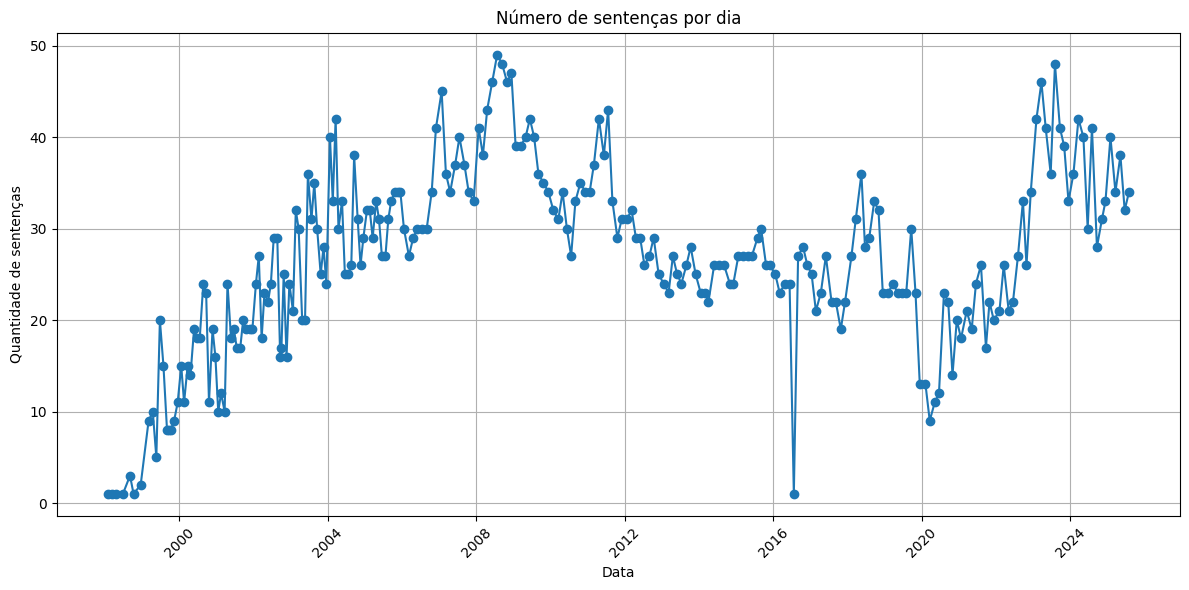

In [4]:
sentencas_por_dia = df.groupby("data").size()
plt.figure(figsize=(12, 6))
plt.plot(sentencas_por_dia.index, sentencas_por_dia.values, marker='o', linestyle='-')
plt.title("Número de sentenças por dia")
plt.xlabel("Data")
plt.ylabel("Quantidade de sentenças")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sentiment Analysis

## SentiLex-PT

In [5]:
arquivo_txt = "inflação/data/lexiconPT/data-raw/SentiLex-lem-PT02.txt"

palavras = []
polaridades = []

with open(arquivo_txt, "r", encoding="utf-8") as f:
    for linha in f:
        partes = linha.strip().split(".PoS=")
        if len(partes) < 2:
            continue
        termo = partes[0].lower()
        if "POL:N0=" in linha:
            polaridade_raw = linha.split("POL:N0=")[1].split(";")[0]
            if polaridade_raw == "1":
                polaridade = "positivo"
            elif polaridade_raw == "-1":
                polaridade = "negativo"
            elif polaridade_raw == "0":
                polaridade = "neutro"
            else:
                continue
            palavras.append(termo)
            polaridades.append(polaridade)

# Cria o DataFrame e salva como CSV
df_lexico = pd.DataFrame({"palavra": palavras, "polaridade": polaridades})
df_lexico.to_csv("sentilex.csv", index=False, encoding="utf-8")

In [6]:
lexico = df_lexico
lexico

,palavra,polaridade
0,à-vontade,positivo
1,abafado,negativo
2,abafante,negativo
3,abaixado,negativo
4,abalado,negativo
...,...,...
6999,zombeteiro,negativo
7000,zonzeira,negativo
7001,zonzo,negativo
7002,zote,negativo


In [7]:
# Cria conjuntos de palavras por polaridade
positivas = set(lexico[lexico["polaridade"] == "positivo"]["palavra"])
negativas = set(lexico[lexico["polaridade"] == "negativo"]["palavra"])

# Função para classificar uma sentença
def classificar_sentimento(sentenca):
    palavras = sentenca.lower().translate(str.maketrans("", "", string.punctuation)).split()
    score = sum(1 for p in palavras if p in positivas) - sum(1 for p in palavras if p in negativas)
    if score > 0:
        return "positivo"
    elif score < 0:
        return "negativo"
    else:
        return "neutro"

In [8]:
# Aplica ao DataFrame
df["sentimento"] = df["sentenca"].apply(classificar_sentimento)

print(df[["data", "sentenca", "sentimento"]].head())

        data                                           sentenca sentimento
0 2019-12-11  No cenário externo, a provisão de estímulos mo...   positivo
1 2019-12-11  Diversas medidas de inflação subjacente encont...   positivo
2 2019-12-11  As expectativas de inflação para 2019, 2020, 2...     neutro
3 2019-12-11  Nesse cenário, as projeções para a inflação de...   positivo
4 2019-12-11  No cenário com trajetória de taxa de juros da ...   positivo


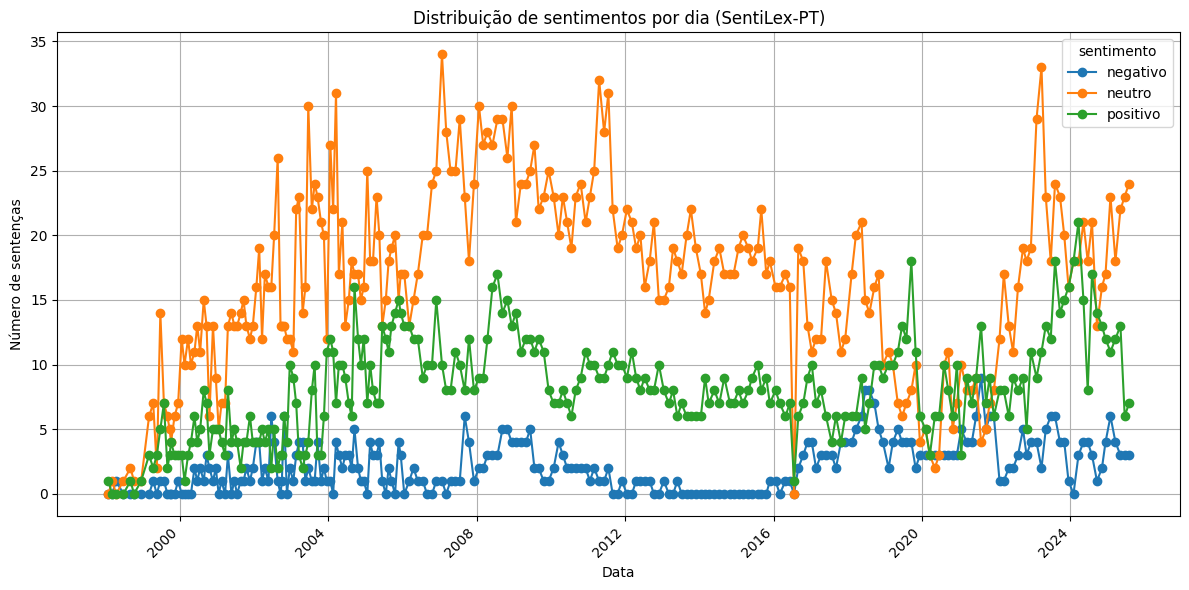

In [9]:
# Conta sentimentos por dia
sentimentos_por_dia = df.groupby(["data", "sentimento"]).size().unstack(fill_value=0)

# Cria o gráfico
sentimentos_por_dia.plot(figsize=(12, 6), marker='o')
plt.title("Distribuição de sentimentos por dia (SentiLex-PT)")
plt.xlabel("Data")
plt.ylabel("Número de sentenças")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## OpLexicon

In [10]:
lexico

,palavra,polaridade
0,à-vontade,positivo
1,abafado,negativo
2,abafante,negativo
3,abaixado,negativo
4,abalado,negativo
...,...,...
6999,zombeteiro,negativo
7000,zonzeira,negativo
7001,zonzo,negativo
7002,zote,negativo


In [11]:
lexico = pd.read_csv("inflação/data/OpLexicon/OpLexicon.csv", header=None, names=["palavra", "classe", "polaridade"])
lexico

,palavra,classe,polaridade
0,abafada,adj,-1
1,abafadas,adj,-1
2,abafado,adj,-1
3,abafados,adj,-1
4,abafante,adj,-1
...,...,...,...
24469,zotes,adj,-1
24470,zumbidor,adj,-1
24471,zumbidora,adj,-1
24472,zumbidoras,adj,-1


In [12]:
# Normaliza os dados
lexico["palavra"] = lexico["palavra"].str.lower()
lexico["polaridade"] = lexico["polaridade"].astype(int)

# Mapeia polaridade numérica para texto
polaridade_map = {-1: "negativo", 0: "neutro", 1: "positivo"}
lexico["polaridade_texto"] = lexico["polaridade"].map(polaridade_map)

In [13]:
# Cria conjuntos por polaridade
positivas = set(lexico[lexico["polaridade_texto"] == "positivo"]["palavra"])
negativas = set(lexico[lexico["polaridade_texto"] == "negativo"]["palavra"])

# Função de classificação
def classificar_sentimento(sentenca):
    palavras = sentenca.lower().translate(str.maketrans("", "", string.punctuation)).split()
    score = sum(1 for p in palavras if p in positivas) - sum(1 for p in palavras if p in negativas)
    if score > 0:
        return "positivo"
    elif score < 0:
        return "negativo"
    else:
        return "neutro"

# Aplica ao DataFrame
df["sentimento_oplexicon"] = df["sentenca"].apply(classificar_sentimento)

In [14]:
df

,data,sentenca,sentimento,sentimento_oplexicon
0,2019-12-11,"No cenário externo, a provisão de estímulos mo...",positivo,positivo
1,2019-12-11,Diversas medidas de inflação subjacente encont...,positivo,positivo
2,2019-12-11,"As expectativas de inflação para 2019, 2020, 2...",neutro,positivo
3,2019-12-11,"Nesse cenário, as projeções para a inflação de...",positivo,positivo
4,2019-12-11,No cenário com trajetória de taxa de juros da ...,positivo,neutro
...,...,...,...,...
6558,2001-10-17,"É importante, contudo, observar que a elevação...",neutro,neutro
6559,2001-10-17,Há evidências sólidas da queda da inércia da i...,negativo,neutro
6560,2001-10-17,A queda da inflação prevista para o quarto tri...,neutro,neutro
6561,2001-10-17,O Copom mantém-se atento aos riscos maiores de...,neutro,positivo


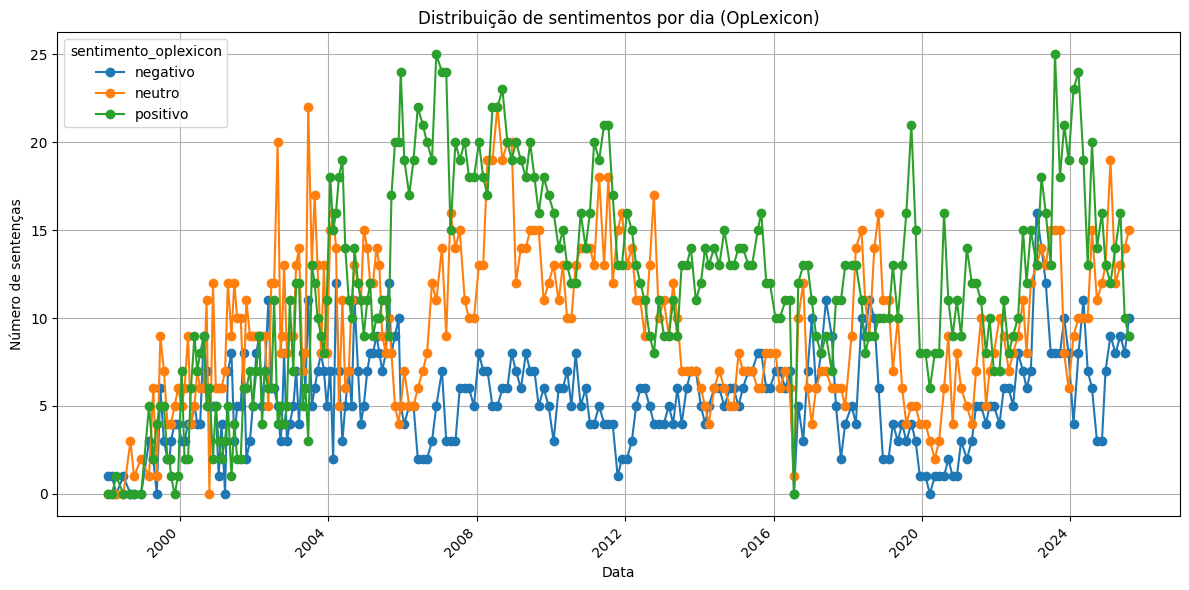

In [15]:
sentimentos_por_dia = df.groupby(["data", "sentimento_oplexicon"]).size().unstack(fill_value=0)


sentimentos_por_dia.plot(figsize=(12, 6), marker='o')
plt.title("Distribuição de sentimentos por dia (OpLexicon)")
plt.xlabel("Data")
plt.ylabel("Número de sentenças")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Word Cloud

In [ ]:
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/u7272942/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
nltk.download('stopwords')
stopwordsPT = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/u7272942/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


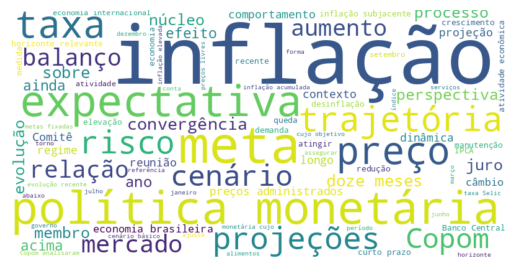

In [28]:
# Wordcloud
text = ' '.join(df['sentenca'].astype(str))
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      stopwords=stopwordsPT,
                      min_font_size=10).generate(text)

# Plot the wordcloud image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()